<a href="https://colab.research.google.com/github/edison0828/generative_ai/blob/main/HW7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📈 股票策略產生機器人

說明 :
這次作業選擇主題一，延續上週作業，更改成可以持續對話的版本。
這是一個基於 OpenAI GPT-4o 的選股策略建議系統，專為 **非專業投資者** 設計。使用者只需輸入簡單的投資需求，例如「我想保守一點、不想每天看盤」，AI 就會自動產生一份適合的交易策略，使用者可以持續和ai對話修改或增強策略。

## 安裝和導入套件

In [11]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

!pip install openai pandas gradio

import os
import time
import openai
import gradio as gr
from google.colab import userdata

## 設定API KEY

In [12]:
# --- OpenAI 設定 ---
try:
    api_key = userdata.get('OpenAI')
    if not api_key:
        raise ValueError("OpenAI API Key not found in Colab secrets. Please add it.")
    os.environ['OPENAI_API_KEY'] = api_key
    client = openai.OpenAI()
    MODEL = "gpt-4o"
    print("OpenAI Client Initialized Successfully.")
except Exception as e:
    print(f"Error initializing OpenAI Client: {e}")
    client = None


OpenAI Client Initialized Successfully.


## 設計股票策略產生機器人

In [13]:
# --- 系統提示 (System Prompt) ---
SYSTEM_PROMPT = """你是一位擅長將股票策略教給新手的金融專家與友善的指導老師。
你的目標是根據使用者的需求，設計一個實用的交易策略，適合專業及非專業投資者使用。
請使用白話文說明配合專業術語，但要解釋清楚專業術語的意思。
如果使用者提出策略需求，請確保最後一定要給一個完整的選股條件範例，需要參考不同的資訊來源（例如：基本面、技術面、籌碼面等），不要只有單一資訊。
範例中的指標要有具體的數值標準（例如：RSI < 30，而不是「較低的 RSI」）。
清楚說明策略的進場和出場條件。
請根據對話的上下文來回應，如果使用者提出澄清或追問，請針對之前的回答進行補充或修改。
如果使用者只是閒聊或提出與策略設計無關的問題，請友善回應，但可以適時引導回策略討論。"""


In [14]:
def chat_fn(message, history):
    if not client:
        yield "錯誤：OpenAI 客戶端未成功初始化，請檢查 API Key 設定。"
        return

    messages = [{"role": "system", "content": SYSTEM_PROMPT}]

    # 歷史紀錄
    for user_msg, assistant_msg in history:
        messages.append({"role": "user", "content": user_msg})
        messages.append({"role": "assistant", "content": assistant_msg})

    # 使用者最新的訊息
    messages.append({"role": "user", "content": message})

    # 呼叫 OpenAI API
    try:
        response = client.chat.completions.create(
            model=MODEL,
            messages=messages,
            stream=True
        )

        full_text = ""
        for chunk in response:
            if chunk.choices and chunk.choices[0].delta and chunk.choices[0].delta.content:
                content = chunk.choices[0].delta.content
                full_text += content
                yield full_text
                # time.sleep(0.02)

    except openai.AuthenticationError as e:
         print(f"OpenAI Authentication Error: {e}")
         yield "錯誤：OpenAI API 金鑰驗證失敗，請檢查您的 API Key 是否正確或有效。"
    except openai.RateLimitError as e:
         print(f"OpenAI Rate Limit Error: {e}")
         yield "錯誤：已達到 OpenAI API 的請求頻率限制，請稍後再試。"
    except openai.APIConnectionError as e:
         print(f"OpenAI API Connection Error: {e}")
         yield "錯誤：無法連接到 OpenAI API，請檢查您的網路連線。"
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        yield f"抱歉，發生未預期的錯誤：{e}"


## Gradio UI

In [15]:
demo = gr.ChatInterface(
    fn=chat_fn,
    title="📈 股票策略產生機器人 ",
    description="輸入你的投資需求（例如「我想要一個長線價值投資策略」），或針對 AI 的回答繼續提問，AI 會記住之前的對話內容。✨",
    theme="soft",
    examples=[ # 範例問題
        "我想要一個適合小資族的短線波段策略",
        "請解釋一下 KD 指標怎麼用在進出場判斷？",
        "剛剛你提到的那個價值投資策略，選股條件可以再嚴格一點嗎？"
    ],
    cache_examples=False
)

demo.launch(debug=True)

if __name__ == "__main__":
    demo.launch(debug=True)

/usr/local/lib/python3.11/dist-packages/gradio/chat_interface.py:338: UserWarning: The 'tuples' format for chatbot messages is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style 'role' and 'content' keys.
  self.chatbot = Chatbot(


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://8405a0d87d116c4e36.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://8405a0d87d116c4e36.gradio.live
Rerunning server... use `close()` to stop if you need to change `launch()` parameters.
----
Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://8405a0d87d116c4e36.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


KeyboardInterrupt: 

# 實際效果截圖

（第一次對話）
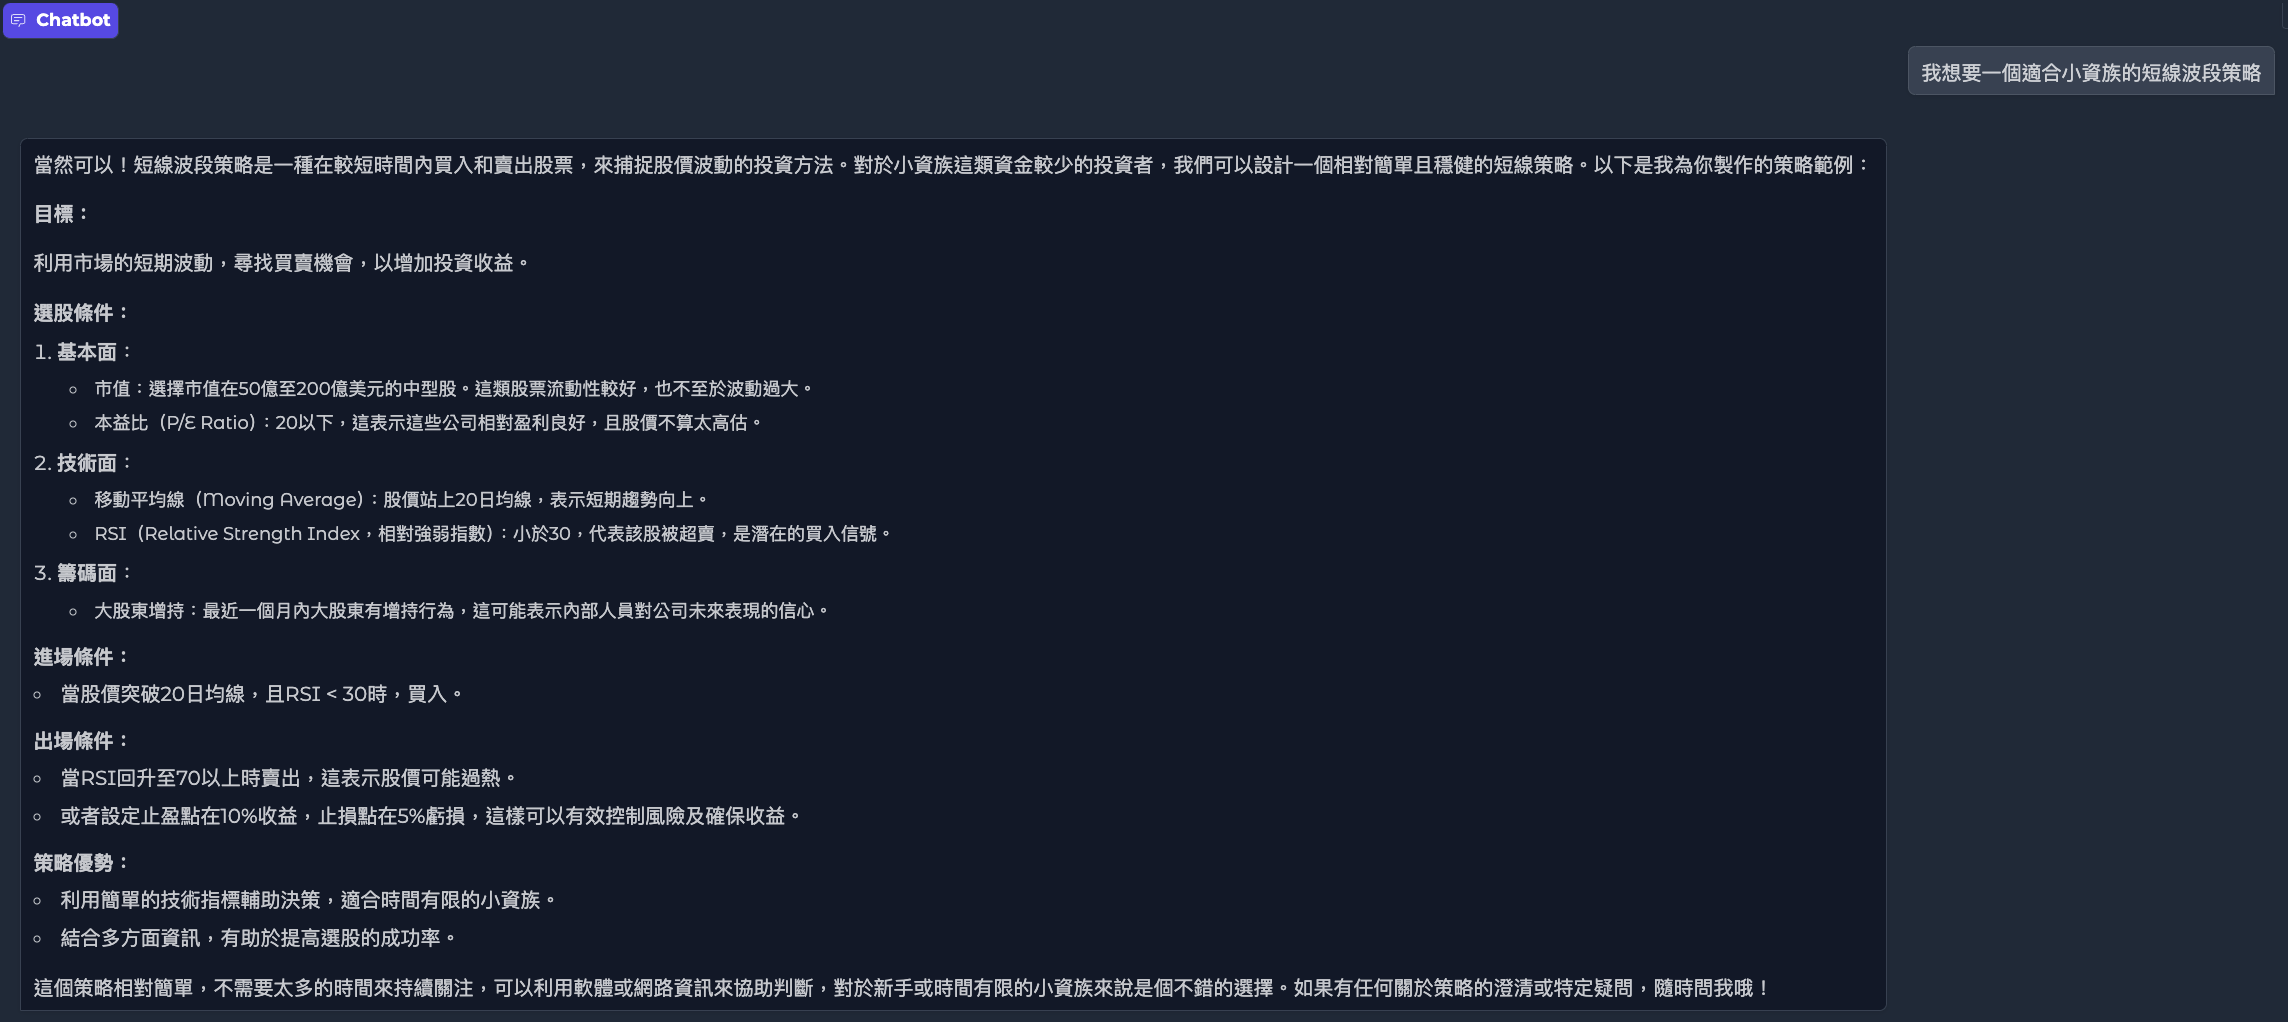

（接續對話）
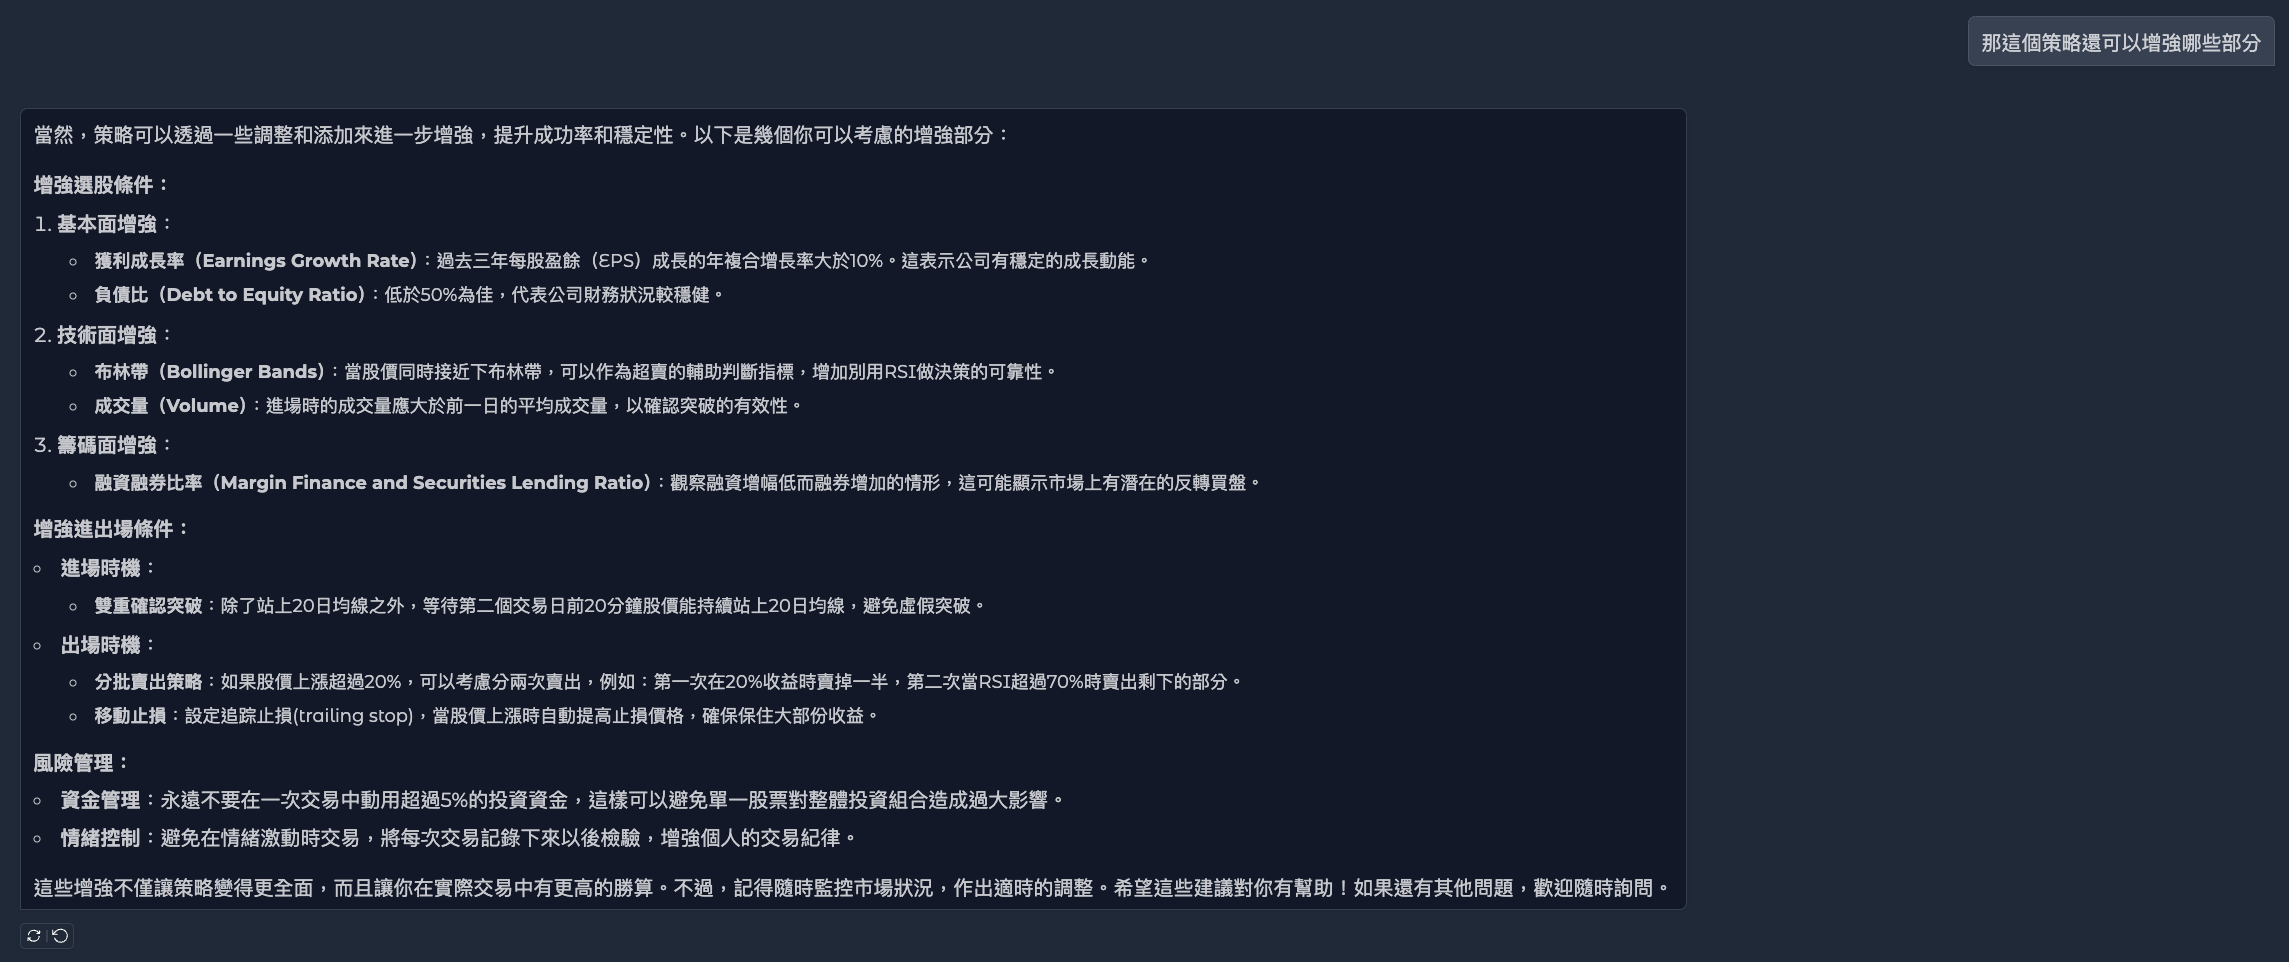